In [2]:
import sys
sys.path.append("..")

from eclipsoid.numpy_src import coeffs, intersection_points, compute_bounds, draw_oblate, draw_oblate_under_planet, compute_bounds_under_planet

import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
%matplotlib inline

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Brute Force 2D vs Numerical 1D integral of an elliptical occultor:

In this notebook, we show that we can successfully use Green's theorem to convert the 2D, expensive integral for the flux blocked during an occultation or transit of an oblate object, to a 1D integral which can be computed in a fraction of a second. First, I write the Green's basis defined in Eq. 11 of the [starry](https://arxiv.org/abs/1810.06559) paper in python code below. This is how we will represent the limb darkening, or any other map of the flux on the surface of the star (or occulted body).

In [3]:
def g(x, y, z=None, n=0):
    """
    Return the nth term of the Green's basis (a scalar).
    
    """
    if z is None:
        z = np.sqrt(1 - x ** 2 - y ** 2)
    l = int(np.floor(np.sqrt(n)))
    m = n - l * l - l
    mu = l - m
    nu = l + m
    if (nu % 2 == 0):
        I = [mu // 2]
        J = [nu // 2]
        K = [0]
        C = [(mu + 2) // 2]
    elif (l == 1) and (m == 0):
        I = [0]
        J = [0]
        K = [1]
        C = [1]
    elif (mu == 1) and (l % 2 == 0):
        I = [l - 2]
        J = [1]
        K = [1]
        C = [3]
    elif (mu == 1):
        I = [l - 3, l - 1, l - 3]
        J = [0, 0, 2]
        K = [1, 1, 1]
        C = [-1, 1, 4]
    else:
        I = [(mu - 5) // 2, (mu - 5) // 2, (mu - 1) // 2]
        J = [(nu - 1) // 2, (nu + 3) // 2, (nu - 1) // 2]
        K = [1, 1, 1]
        C = [(mu - 3) // 2, -(mu - 3) // 2, -(mu + 3) // 2]
    res = 0
    for i, j, k, c in zip(I, J, K, C):
        res += c * x ** i * y ** j * z ** k
    return res

Next, I define the anti-exterior derivative of each term in Green's basis in python code below, which is defined in Eq. 34 of the starry paper below:

In [4]:
def G(n):
    """
    Return the anti-exterior derivative of the nth term of the Green's basis.
    This is a two-dimensional (Gx, Gy) vector of functions of x and y.
    
    """
    # Get the mu, nu indices
    l = int(np.floor(np.sqrt(n)))
    m = n - l * l - l
    mu = l - m
    nu = l + m

    # NOTE: The abs prevents NaNs when the argument of the sqrt is
    # zero but floating point error causes it to be ~ -eps.
    z = lambda x, y: np.maximum(1e-12, np.sqrt(np.abs(1 - x ** 2 - y ** 2)))

    if nu % 2 == 0:
        
        G = [lambda x, y: 0, lambda x, y: x ** (0.5 * (mu + 2)) * y ** (0.5 * nu)]
    
    elif (l == 1) and (m == 0):

        def G0(x, y):
            z_ = z(x, y)
            if z_ > 1 - 1e-8:
                return -0.5 * y
            else:
                return (1 - z_ ** 3) / (3 * (1 - z_ ** 2)) * (-y)

        def G1(x, y):
            z_ = z(x, y)
            if z_ > 1 - 1e-8:
                return 0.5 * x
            else:
                return (1 - z_ ** 3) / (3 * (1 - z_ ** 2)) * x

        G = [G0, G1]

    elif (mu == 1) and (l % 2 == 0):
        
        G = [lambda x, y: x ** (l - 2) * z(x, y) ** 3, lambda x, y: 0]
    
    elif (mu == 1) and (l % 2 != 0):
        
        G = [lambda x, y: x ** (l - 3) * y * z(x, y) ** 3, lambda x, y: 0]
    
    else:
        
        G = [
            lambda x, y: 0,
            lambda x, y: x ** (0.5 * (mu - 3))
            * y ** (0.5 * (nu - 1))
            * z(x, y) ** 3,
        ]
        
    return G

Now, I define certain routines for the integration itself. In this case, the primitive integral is just a simple way of performing a 1D integral where we have a parametric equation plugged into Gn (defined above). The $Q$ integral, a line integral around the boundary of the star, and the $P$ integral, the corresponding line integral around the boundary of the planet, are defined as well. Remember that the $P$ integral parametrizes an ellipse in the integrand instead of a circle as in the original starry paper. 

Lastly, I define a brute force integral that, for a given term in Green's basis, sums up the product of the intensity of the 2d "pixel" and the area of the pixel for all pixels under the occultor. 

In [5]:
def primitive(x, y, dx, dy, theta1, theta2, n=0):
    """A general primitive integral computed numerically."""

    def func(theta):
        Gx, Gy = G(n)
        return Gx(x(theta), y(theta)) * dx(theta) + Gy(x(theta), y(theta)) * dy(theta)

    res, _ = quad(func, theta1, theta2, epsabs=1e-12, epsrel=1e-12)
    return res


def qT(xi, n=0):
    """Compute the tT integral numerically from its integral definition."""
    res = 0
    for xi1, xi2 in xi.reshape(-1, 2):
        x = lambda xi: np.cos(xi)
        y = lambda xi: np.sin(xi)
           
        dx = lambda xi: -np.sin(xi)
        dy = lambda xi: np.cos(xi)
        res += primitive(x, y, dx, dy, xi1, xi2, n=n)
    return res



def pT(phi, b, xo, yo, ro, n=0):
    """Compute the pT integral numerically from its integral definition."""
    res = 0
    for phi1, phi2 in phi.reshape(-1, 2):
        x = lambda phi: ro * np.cos(phi) + xo
        y = lambda phi: ro * b * np.sin(phi) + yo
        
        dx = lambda phi: -ro * np.sin(phi)
        dy = lambda phi: b * ro * np.cos(phi)
        res += primitive(x, y, dx, dy, phi1, phi2, n)
    return res

def sT(phi, xi, b, xo, yo, ro, n=0):
    """The solution vector for occultations, computed via Green's theorem."""
    return pT(phi, b, xo, yo, ro, n) + qT(xi, n)

def sT_bruteforce(b, xo, yo, ro, n=0, res=300):

    # Create a fine grid
    pts = np.linspace(-1.0, 1.0, res)
    x, y = np.meshgrid(pts, pts)

    # Check if a point is inside the circle of the star
    in_star = (x ** 2) + (y ** 2) <= 1

    # Check if a point is under the occultor
    under_occultor = (x-xo) ** 2 + ((y - yo)/b) ** 2 <= ro ** 2

    
    # Now, compute the nth term in the basis...
    term = g(x, y, n=n)
    
    # And sum it over the integration region
    # Each pixel has area dA = (area of square) / (number of pixels)
    dA = 4 / (x.shape[0] * x.shape[1])
    integral = np.sum(term[in_star & under_occultor] * dA)
    
    return x, y, term, under_occultor, in_star, integral

## Circular case:

First, to ensure that the integrals we are performing reduce to the starry paper's when the planet is circular, we set the oblateness of the planet to 0 and test the brute force integral against the numerical integral:

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

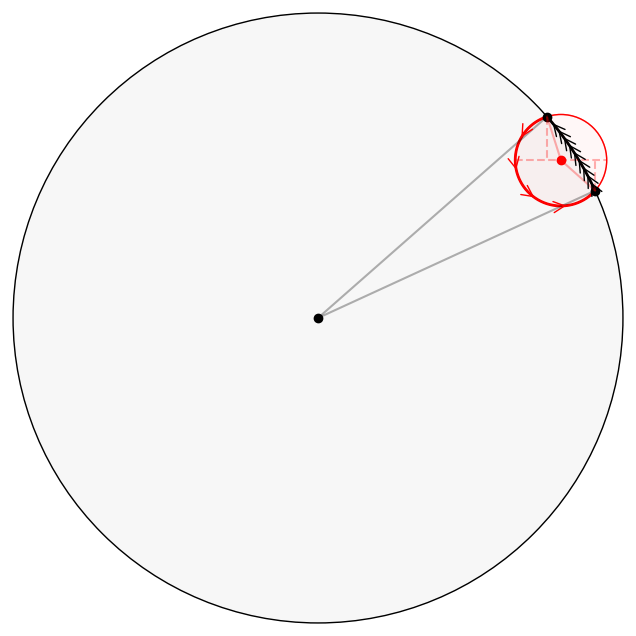

In [6]:
b = 1.0
bo = 0.95
ro = 0.15
theta = np.radians(33)

xo = bo*np.cos(theta)
yo = bo*np.sin(theta)

draw_oblate_under_planet(b,xo,yo,ro)

In [7]:
xi, phi = compute_bounds_under_planet(b,xo,yo,ro)
print(np.degrees(xi))

[24.67934481 41.32065519]


In [8]:
from tqdm.notebook import tqdm
numerical_circ = np.zeros(16)
for n in tqdm(range(16)):
    x, y, term, under_occultor, in_star, numerical_circ[n] = sT_bruteforce(b,xo,yo,ro, n=n, res=3999)

  0%|          | 0/16 [00:00<?, ?it/s]

/var/folders/_t/bqm0d4gd4gb4w_d2p9j445h00000gq/T/ipykernel_61766/2353778927.py:7: RuntimeWarning: invalid value encountered in sqrt
  z = np.sqrt(1 - x ** 2 - y ** 2)


In [9]:
semi_analytic_circ = np.zeros(16)
for n in tqdm(range(16)):
    semi_analytic_circ[n] = sT(phi, xi,b,xo,yo,ro, n=n)

  0%|          | 0/16 [00:00<?, ?it/s]

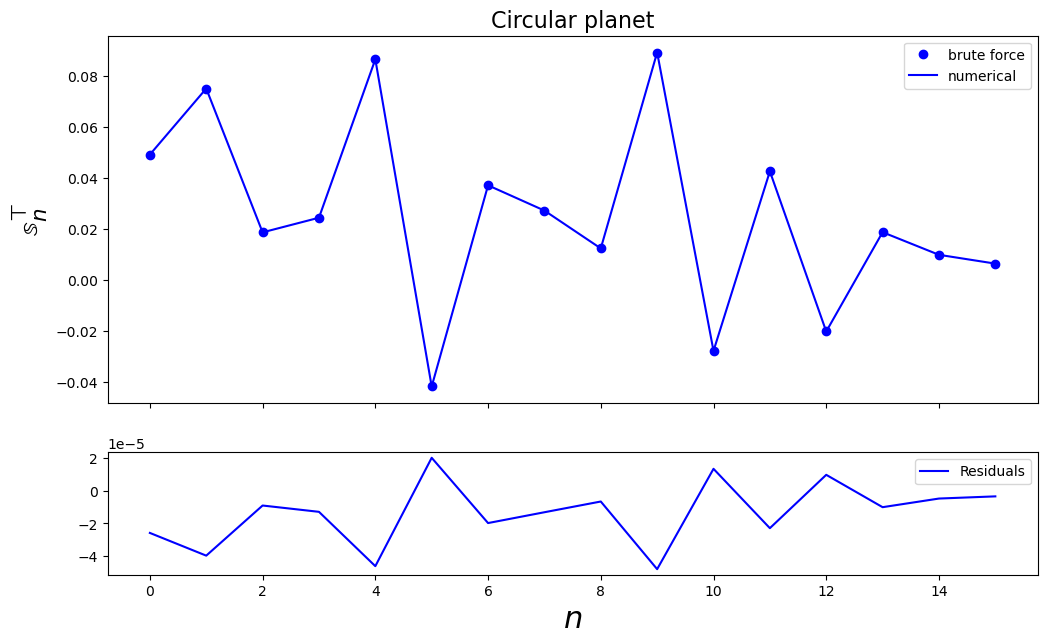

In [10]:
fig, ax = plt.subplots(2,1, figsize=(12, 7), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
ax[0].plot(numerical_circ,'bo', label="brute force")
ax[0].plot(semi_analytic_circ,'b-',label='numerical')
ax[0].set_title("Circular planet", fontsize='16')

ax[1].plot(numerical_circ-semi_analytic_circ,'b-',label='Residuals')

ax[0].legend()
ax[1].legend()
plt.xlabel(r"$n$", fontsize=22)
ax[0].set_ylabel(r"$\mathbb{s}_n^\top$", fontsize=22);

## Elliptical planet

Finally, we do the actual integral we are interested in--the integral of an elliptical planet. Due to the numerical precision of a brute force integral, we exaggerate the oblateness of the planet beyond what would be physically realistic: the polar radius is taken to be half the equatorial radius.

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

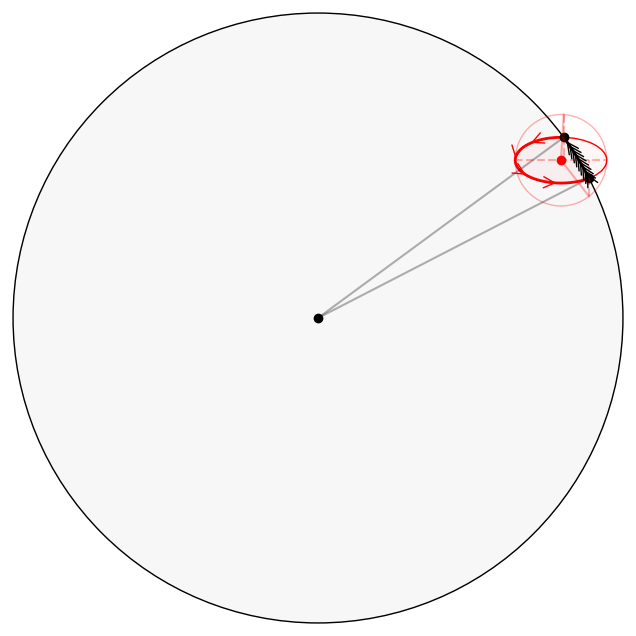

In [11]:
b = 0.5
bo = 0.95
ro = 0.15
theta = np.radians(33)

xo = bo*np.cos(theta)
yo = bo*np.sin(theta)

draw_oblate_under_planet(b,xo,yo,ro)

In [12]:
xi, phi = compute_bounds_under_planet(b,xo,yo,ro)
print(np.degrees(xi))

[27.27176029 36.31839742]


In [13]:
from tqdm.notebook import tqdm
numerical_obl = np.zeros(16)
for n in tqdm(range(16)):
    x, y, term, under_occultor, in_star, numerical_obl[n] = sT_bruteforce(b,xo,yo,ro, n=n, res=3999)

  0%|          | 0/16 [00:00<?, ?it/s]

/var/folders/_t/bqm0d4gd4gb4w_d2p9j445h00000gq/T/ipykernel_61766/2353778927.py:7: RuntimeWarning: invalid value encountered in sqrt
  z = np.sqrt(1 - x ** 2 - y ** 2)


In [14]:
semi_analytic_obl = np.zeros(16)
for n in tqdm(range(16)):
    semi_analytic_obl[n] = sT(phi, xi,b,xo,yo,ro, n=n)

  0%|          | 0/16 [00:00<?, ?it/s]

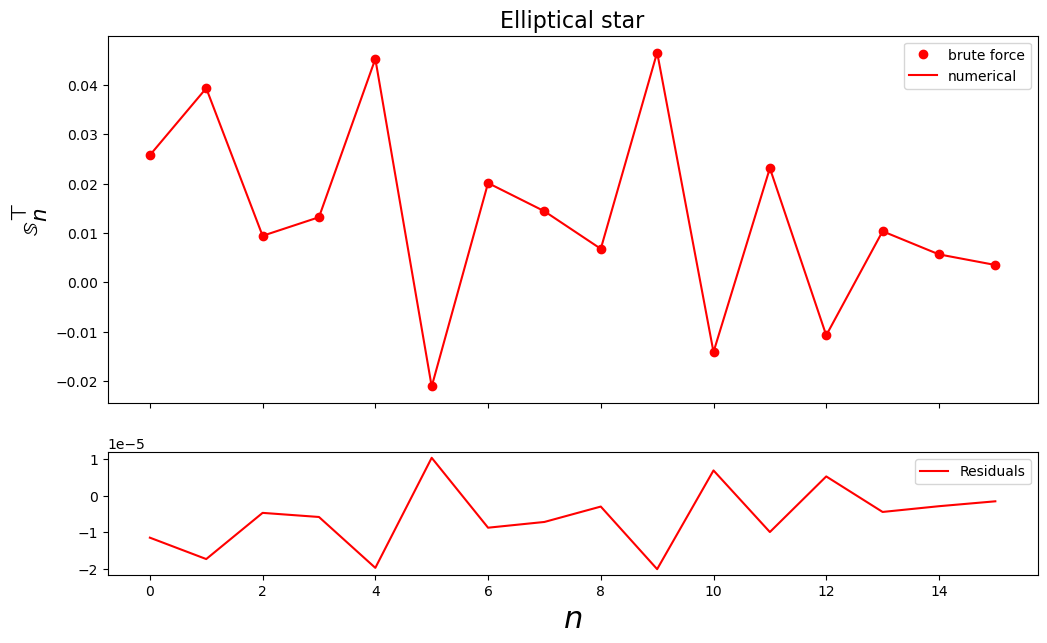

In [15]:
fig, ax = plt.subplots(2,1, figsize=(12, 7), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
ax[0].set_title("Elliptical star", fontsize='16')
ax[0].plot(numerical_obl,'ro', label="brute force")
ax[0].plot(semi_analytic_obl,'r-',label='numerical')


ax[1].plot(numerical_obl-semi_analytic_obl,'r-',label='Residuals')

ax[0].legend()
ax[1].legend()
plt.xlabel(r"$n$", fontsize=22)
ax[0].set_ylabel(r"$\mathbb{s}_n^\top$", fontsize=22);

We can see that the end result matches to the same precision as the circular case, to a value about one part in 100,000. Since the numerical integral is performed with a precision of 1e-12, if we performed the brute force integral to higher precision, we would expect even better residuals. Note also that even with this non-jaxified integration code, a single integral of a term in Gn takes less than a millisecond!

## Analytically computing the qT integral:

First, I take directly from [this notebook](https://github.com/rodluger/starrynight/blob/5f79b24026133db207a88bee465e5e5080b64bcf/tex/proofs/qT.ipynb) and show that the same formula for computing the stellar boundary integral for reflected light, except with bounds of integration of the oblate planet, can replicate the qT integral exactly with the numerical version above.

In [41]:
def computeH(umax, vmax, lam):
    """
    The matrix H evaluated by direct numerical integration.
    
    """
    H = np.zeros((umax + 1, vmax + 1))
    for u in range(umax + 1):
        for v in range(vmax + 1):
            for i in range(0, len(lam), 2):
                func = lambda x: np.cos(x) ** u * np.sin(x) ** v
                H[u, v] += quad(func, lam[i], lam[i + 1], epsabs=1e-12, epsrel=1e-12,)[0]
    return H


def qT_analytic(deg, lam):
    """
    Compute the qT integral, evaluated in terms of the integral H.
    
    """
    # Initialize
    N = (deg + 1) ** 2
    qT = np.zeros(N) * np.nan

    # Pre-compute the helper integral
    H = computeH(deg + 2, deg + 2, lam)

    for n in range(N):

        # Get the mu, nu indices
        l = int(np.floor(np.sqrt(n)))
        m = n - l * l - l
        mu = l - m
        nu = l + m

        # Cases!
        if mu % 2 == 0:
            
            qT[n] = H[(mu + 4) // 2, nu // 2]
            
        elif mu == nu == 1:
            
            qT[n] = sum(-np.array(lam)[::2] + np.array(lam)[1::2]) / 3.0
            
        else:
            
            qT[n] = 0

    return qT

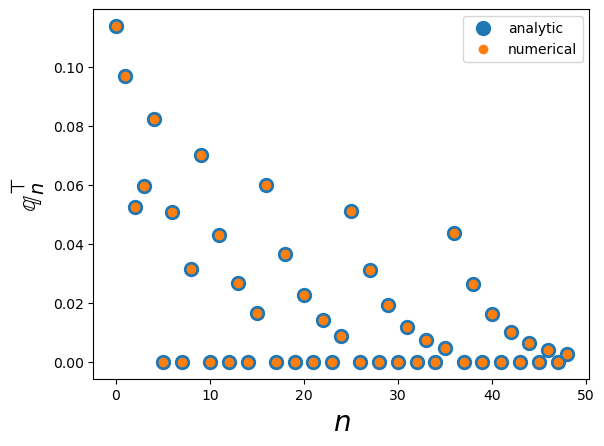

In [42]:
plt.plot(qT_analytic(6, xi), "C0o", label="analytic", ms=10)
plt.plot([qT(xi, n=n) for n in range((6 + 1) ** 2)], "C1o", label="numerical")
plt.legend()
plt.xlabel(r"$n$", fontsize=20)
plt.ylabel(r"$\mathbb{q}_n^\top$", fontsize=20);

Lastly, I show that a modification of [jaxoplanet's q_integral](https://github.com/exoplanet-dev/jaxoplanet/blob/717a504bd43dfa8fc81e0374325610c3b1b7e311/src/jaxoplanet/experimental/starry/solution.py#L38-L75) for our formula solves our problem exactly.

In [43]:
import jax.numpy as jnp

def delta(lam):
    return lam[1] - lam[0]

def q_integral(l_max, lam):
    c = jnp.cos(lam)
    s = jnp.sin(lam)
    h = {
        (0, 0): delta(lam),
        (1, 0): delta(s),
        (0, 1): -delta(c),
        (1, 1): -delta(c**2)/2
    }

    def get(u: int, v: int):
        if (u, v) in h:
            return h[(u, v)]
        if (u < 2) and (v >=2):
            term = c**(u+1)*s**(v-1)
            comp = (- delta(term) + (v-1)*get(u, v-2))
        else:
            term = c**(u-1)*s**(v+1)
            comp = (delta(term) + (u-1)*get(u-2, v))
        comp /= u + v
        h[(u, v)] = comp
        return comp

    U = []
    for l in range(l_max + 1):  # noqa
        for m in range(-l, l + 1):
            if l == 1 and m == 0:
                U.append((delta(lam)) / 3)
                continue
            mu = l - m
            nu = l + m
            if (mu % 2) == 0 and (nu % 2) == 0:
                u = mu // 2 + 2
                v = nu // 2
                U.append(get(u, v))
            else:
                U.append(0)

    return jnp.stack(U)

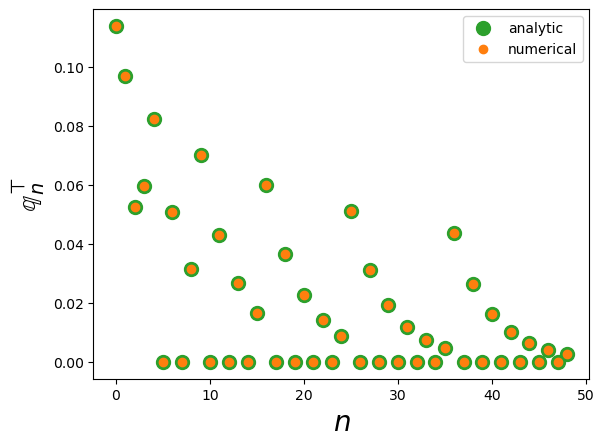

In [44]:
plt.plot(q_integral(6, xi), "C2o", label="analytic", ms=10)
plt.plot([qT(xi, n=n) for n in range((6 + 1) ** 2)], "C1o", label="numerical")
plt.legend()
plt.xlabel(r"$n$", fontsize=20)
plt.ylabel(r"$\mathbb{q}_n^\top$", fontsize=20);